In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as wnl
from nltk.stem import PorterStemmer
import re
import matplotlib.pyplot as plt
import seaborn as sns


def lemmatize_tokenizer(text):
    """Tokenizes text and lemmatizes tokens for TF-IDF vectorizer"""
    tokens = tokenize_words(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    lowercase=True,
    tokenizer=lemmatize_tokenizer,  # Use custom tokenizer
    min_df=2,
    max_df=0.90
)

stemmer = PorterStemmer()
lemmatizer = wnl()

# Initialize Count Vectorizer for bag-of-words
# count_vectorizer = CountVectorizer(
#     max_features=1000,
#     stop_words='english',
#     lowercase=True,
#     token_pattern=r'(?u)\b\w{3,}\b',
#     min_df=2,
#     max_df=0.90
# )

def clean_utf_characters(text):
    """
    Clean UTF characters from text, including zero-width characters, 
    emoji, and other non-printable Unicode characters.
    
    Parameters:
    text (str): Input text containing UTF characters
    
    Returns:
    str: Cleaned text with UTF characters removed or normalized
    """
    if not isinstance(text, str):
        return text
    
    # Remove zero-width characters (like \u200c, \u200d, etc.)
    zero_width_chars = [
        '\u200b',  # zero-width space
        '\u200c',  # zero-width non-joiner
        '\u200d',  # zero-width joiner
        '\u2060',  # word joiner
        '\ufeff',  # byte order mark
        '\u200e',  # left-to-right mark
        '\u200f',  # right-to-left mark
        '\u202a',  # left-to-right embedding
        '\u202b',  # right-to-left embedding
        '\u202c',  # pop directional formatting
        '\u202d',  # left-to-right override
        '\u202e',  # right-to-left override
    ]
    
    for char in zero_width_chars:
        text = text.replace(char, '')
    
    # Remove other invisible/control characters
    text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\x9f]', '', text)
    
    # Remove or replace emoji and other Unicode symbols
    # Keep basic punctuation but remove decorative symbols
    text = re.sub(r'[^\w\s\.\,\!\?\;\:\-\(\)\[\]\{\}\'\"\/\\\@\#\$\%\^\&\*\=\+\|`~]', ' ', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

def clean_dataframe_column(df, column_name):
    """
    Apply UTF cleaning to a specific column in a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    column_name (str): Name of the column to clean
    
    Returns:
    pandas.DataFrame: DataFrame with cleaned column
    """
    if column_name not in df.columns:
        print(f"Warning: Column '{column_name}' not found in DataFrame")
        return df
    
    # Create a copy to avoid modifying original
    df_cleaned = df.copy()
    
    # Apply cleaning function to the specified column
    df_cleaned[column_name] = df_cleaned[column_name].apply(clean_utf_characters)
    
    return df_cleaned


# test_text = "Moran Minute: He is Risen! ✝️ As We Celebrate Easter, Here\\'s What I\\'m Working on for East Texas \u200c \u200c \u200c \u200c"
# print("Original text:")
# print(repr(test_text))
# print("\nCleaned text:")
# cleaned = clean_utf_characters(test_text)
# print(repr(cleaned))
# print(f"\nCleaned text (readable): {cleaned}")

def tokenize_words(text, remove_stop_words=True):
    """
    Optimized tokenization with better preprocessing order.
    """
    if isinstance(text, list):
        text = ' '.join(text)

    # Basic text normalization BEFORE tokenization
    text = re.sub(r'\s+', ' ', text.strip())  # Normalize whitespace
    custom_lemma_dict = {'voting': 'vote'}
    # Tokenize first (this is correct!)
    tokenizer = TweetTokenizer()
    words = tokenizer.tokenize(text)
    
    # Now clean the tokens
    words = [re.sub(r"[^\w]", '', word) for word in words]  # Remove punctuation
    words = [word.lower() for word in words]  # Lowercase
    words = [word for word in words if word]  # Remove empty strings
    
    # Filter short words
    words = [word for word in words if len(word) > 1 or word in ['i']]
    words = [word for word in words if word != 'ni']
    
    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]
    words = [custom_lemma_dict.get(word, word) for word in words]

    # compare to stem - uh no
    # words = [stemmer.stem(word) for word in words]

    new_custom_stopwords = ['ha', 'wa']
    
    # Remove stopwords if the option is selected
    if remove_stop_words:
        try:
            stop_words = set(stopwords.words('english'))
            stop_words.update(new_custom_stopwords)
            words = [word for word in words if word.lower() not in stop_words]
        except LookupError:
            print("Warning: Could not load NLTK stopwords. Proceeding without stopword removal.")
            # Fallback to basic stopwords
            basic_stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should'}
            words = [word for word in words if word.lower() not in basic_stopwords]

    return words

def get_bag_of_words(words):
    """
    Generates word frequency data including counts and probabilities.
    
    Parameters:
    - words (list): List of words to analyze for frequency.
    
    Returns:
    - DataFrame: DataFrame with word counts.
    """
    bow = pd.Series(words).value_counts().reset_index()
    bow.columns = ['word', 'counts']        
    # bow['total_unique'] = len(bow)
    bow = bow.sort_values(by='counts', ascending=False).reset_index(drop=True)
    # print total number of words
    print(f"Total number of words in bag of words: {len(bow)}")

    return bow

# def get_bag_of_words(texts):
#     """
#     Alternative implementation using CountVectorizer
    
#     Parameters:
#     - texts (list): List of raw text documents
    
#     Returns:
#     - DataFrame: DataFrame with word counts
#     """
    
#     count_matrix = count_vectorizer.fit_transform(texts)
#     feature_names = count_vectorizer.get_feature_names_out()
    
#     total_counts = np.sum(count_matrix.toarray(), axis=0)
    
#     bow_df = pd.DataFrame({
#         'word': feature_names,
#         'counts': total_counts
#     }).sort_values('counts', ascending=False).reset_index(drop=True)
    
#     print(f"Total number of words in bag of words: {len(bow_df)}")
    
#     return bow_df


# 1.1: Corpus selection and metadata

For this project, I chose to work with a politically themed dataset spanning 2010-2025. The key feature of the dataset is the "Body" column, which is comprised of emails written by congressional members to their constituents. In addition to the email content, each row contains information about the congressional member, including district, state, chamber, and first and last name.
### Research Question
My question in analyzing this dataset was: How does the language of othering and fearmongering congressional members use differ across party lines? 
### Initial Findings
Using a simple word frequency counting approach, patterns and potential narratives begin to surface. An interesting pattern is that both sides frequently reference the opposing party's leadership—Republicans frequently mention Biden, while Democrats frequently mention Trump. Both parties demonstrate high focus on elections, suggesting the political salience of electoral processes in congressional communications.
Most notably, both parties place considerable emphasis on "security." However, based on other frequently appearing words, one could speculate that "security" carries very different meanings depending on which side of the aisle representatives occupy. On the Republican side, "border" appears as a term of seemingly high significance, while on the Democratic side, "health" and "rights" feature prominently. This suggests that Republicans may frame security primarily through immigration and border control, while Democrats may conceptualize security through healthcare access and civil rights protection.
### Data Limitations and Considerations
It should be noted that this initial examination of the data is somewhat cursory and has several limitations that warrant further investigation:
**Partisan Imbalance:** The dataset contains more than a 2:1 ratio of Republican records to Democratic records.
**Distribution over time:** While the records span 15 years (2010-2025), they are heavily skewed toward 2018-2024, with earlier years represented by dozens of records and later years by hundreds. This temporal imbalance may reflect both increased digital communication practices and potential collection biases.
**Chamber Representation:** The dataset presents challenges for chamber-based analysis, containing 1,506 House records compared to only 171 Senate records. This disparity limits the ability to draw meaningful comparisons between the two chambers.
### Future Research Directions
Other potentially interesting analytical dimensions include filtering by gender and state, which could reveal additional patterns in political communication strategies. A more sophisticated analysis might address the data imbalances through sampling techniques or weighted approaches, and could employ more advanced NLP methods beyond simple word counting to capture semantic differences in how parties discuss similar topics.

# Task 1.2: Text Cleaning
- Load your text(s) into Python.
- Do basic prepossessing on the text: convert text to lowercase, stem or lemmatize text, remove stop words, and drop (this is actually done in my tokenize method below)
punctuation
- Explain why doing these preprocessing steps would not or would not be ideal for your research question (in writeup)

In [527]:
# create and merge dataframes
df_f = pd.read_csv('./Data/dcinbox_export__election_f.csv')
df_i = pd.read_csv('./Data/dcinbox_export__election_i.csv')
df_s = pd.read_csv('./Data/dcinbox_export__election_s.csv')
df_frau = pd.read_csv('./Data/dcinbox_export__voter_frau.csv')
df = pd.concat([df_f, df_i, df_s, df_frau])
df = df.drop_duplicates(subset=['ID', 'Unix Timestamp', 'State', 'Chamber', 'Party', 'Body'], keep='first')
df = clean_dataframe_column(df, 'Body')
df.head(10)
# print(df.shape)

# print(df.State.value_counts())
# print(df.State.unique())
# print(df.Chamber.value_counts())
# print(df.Party.value_counts())

# print(df.info())


,Subject,Body,Unix Timestamp,BioGuide ID,Congress,First Name,Last Name,Date of Birth,Gender,State,District,Party,Chamber,Nickname,ID
0,Moran Minute: He is Risen! ✝️,Moran Minute: He is Risen! As We Celebrate Eas...,1745073029000,M001224,119,Nathaniel,Moran,1974-07-22,M,TX,1.0,Republican,House,NaN,252343
1,"Week of March 31, 2025",News from Congressman Abe Hamadeh [image: Imag...,1743737940000,H001098,119,Abraham,Hamadeh,1991-05-15,M,AZ,8.0,Republican,House,NaN,251587
2,It's a New Day at the Southern Border,It's a New Day at the Southern Border Securing...,1743345352000,B001291,119,Brian,Babin,1948-03-23,M,TX,36.0,Republican,House,NaN,251278
3,Rep. Randy Weber e-Newsletter,Rep. Randy Weber e-Newsletter Introducing Cens...,1743181448000,W000814,119,Randy,Weber,1953-07-02,M,TX,14.0,Republican,House,NaN,251173
4,Mario's Message,"Email from Rep. Diaz-Balart February 04, 2025 ...",1738661804000,D000600,119,Mario,Diaz-Balart,1961-09-25,M,FL,26.0,Republican,House,NaN,248655
5,Reminder: Randy's Roundup: Do you think that e...,Email from Rep Feenstra In this week's roundup...,1732541491000,F000446,118,Randy,Feenstra,1969-01-14,M,IA,4.0,Republican,House,NaN,245957
6,This Week With Claudia #NY24,Email from Rep. Tenney Congresswoman Tenney's ...,1732366837000,T000478,118,Claudia,Tenney,1961-02-04,F,NY,24.0,Republican,House,NaN,245910
7,Randy's Roundup: Do you think that every ballo...,Email from Rep Feenstra In this week's roundup...,1732294227000,F000446,118,Randy,Feenstra,1969-01-14,M,IA,4.0,Republican,House,NaN,245842
8,Antidote Election,It's not too hard for Ravens fans to picture o...,1730541843000,C000141,118,Benjamin,Cardin,1943-10-05,M,MD,NaN,Democrat,Senate,NaN,245128
9,July 2024 Month in Review _ Resumen del Mes de...,La versión en español está a continuación Hell...,1724168425000,G000551,118,Raúl,Grijalva,1948-02-19,M,AZ,7.0,Democrat,House,NaN,242026


# Task 1.3: Tokenization
- Implement a tokenizer of your choosing
- Document why you chose the tokenization method (in writeup)

In [528]:
words = df['Body'].values.tolist()
tokenized_words = tokenize_words(words)

# Task 2.1: Bag-of-Words Representation
- Construct a Bag-of-Words (BoW) model from your corpus using scikit-learn
- Identify the top 20 most frequent words
- Compare whether they match the themes you anticipated from your reading. (in writeup)

In [529]:
bow = get_bag_of_words(tokenized_words)
top_20_bow = bow.head(20)
top_20_bow.index += 1
print(top_20_bow)

Total number of words in bag of words: 39997
           word  counts
1      election    8044
2        office    7407
3         state    7126
4           act    6658
5      american    6286
6         house    6246
7          week    5963
8          vote    5784
9          bill    5606
10   washington    4817
11     congress    4682
12      federal    4664
13    president    4424
14         year    4340
15        click    4338
16          new    3941
17        would    3794
18     district    3563
19  legislation    3562
20     security    3519


In [530]:
r_df = df[df['Party'] == 'Republican']
d_df = df[df['Party'] == 'Democrat']

r_words = r_df['Body'].values.tolist()
d_words = d_df['Body'].values.tolist()

r_words = tokenize_words(r_words)
d_words = tokenize_words(d_words)

r_bow = get_bag_of_words(r_words)
d_bow = get_bag_of_words(d_words)

print('Republican Bag of Words:')
print(r_bow.head(20))
print('_'*100)
print('Democrat Bag of Words:')
print(d_bow.head(20))


Total number of words in bag of words: 32153
Total number of words in bag of words: 21665
Republican Bag of Words:
           word  counts
0      election    5866
1        office    5397
2         state    5292
3      american    4852
4           act    4665
5         house    4589
6          week    4576
7          bill    4056
8          vote    3719
9    washington    3503
10     congress    3449
11      federal    3433
12        click    3204
13    president    3110
14         year    3064
15        would    2760
16          new    2736
17     district    2616
18       border    2615
19  legislation    2606
____________________________________________________________________________________________________
Democrat Bag of Words:
          word  counts
0     election    2178
1         vote    2065
2       office    2010
3          act    1993
4        state    1834
5        house    1657
6         bill    1550
7     american    1434
8         week    1387
9   washington    1314
10  

# Task 2.2: TF–IDF Representation
- Construct a TF-IDF representation of your corpus.
- Plot the top TF-IDF–scored words for your text using a bar chart.
- Compare TF-IDF keywords with BoW keywords: what’s different? Which representation is more meaningful for thematic analysis? (in writeup)

In [531]:
print(f"Calculating TF-IDF for entire dataset ({len(df)} documents)...")
full_tfidf_matrix = tfidf_vectorizer.fit_transform(df['Body'])
full_feature_names = tfidf_vectorizer.get_feature_names_out()

full_mean_scores = np.mean(full_tfidf_matrix.toarray(), axis=0)
full_tfidf_df = pd.DataFrame({
    'word': full_feature_names,
    'tfidf_score': full_mean_scores
}).sort_values('tfidf_score', ascending=False)

print("Top 15 TF-IDF words across entire dataset:")
print(full_tfidf_df.head(15).to_string(index=False))

Calculating TF-IDF for entire dataset (1677 documents)...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['u'] not in stop_words.
  warnings.warn(


Top 15 TF-IDF words across entire dataset:
      word  tfidf_score
      vote     0.060070
     state     0.057887
       act     0.055778
     house     0.054449
      week     0.053717
  american     0.053230
     click     0.046347
washington     0.045493
 president     0.043186
  congress     0.041574
   federal     0.040833
     phone     0.039480
       new     0.038642
     voter     0.038248
      year     0.037882


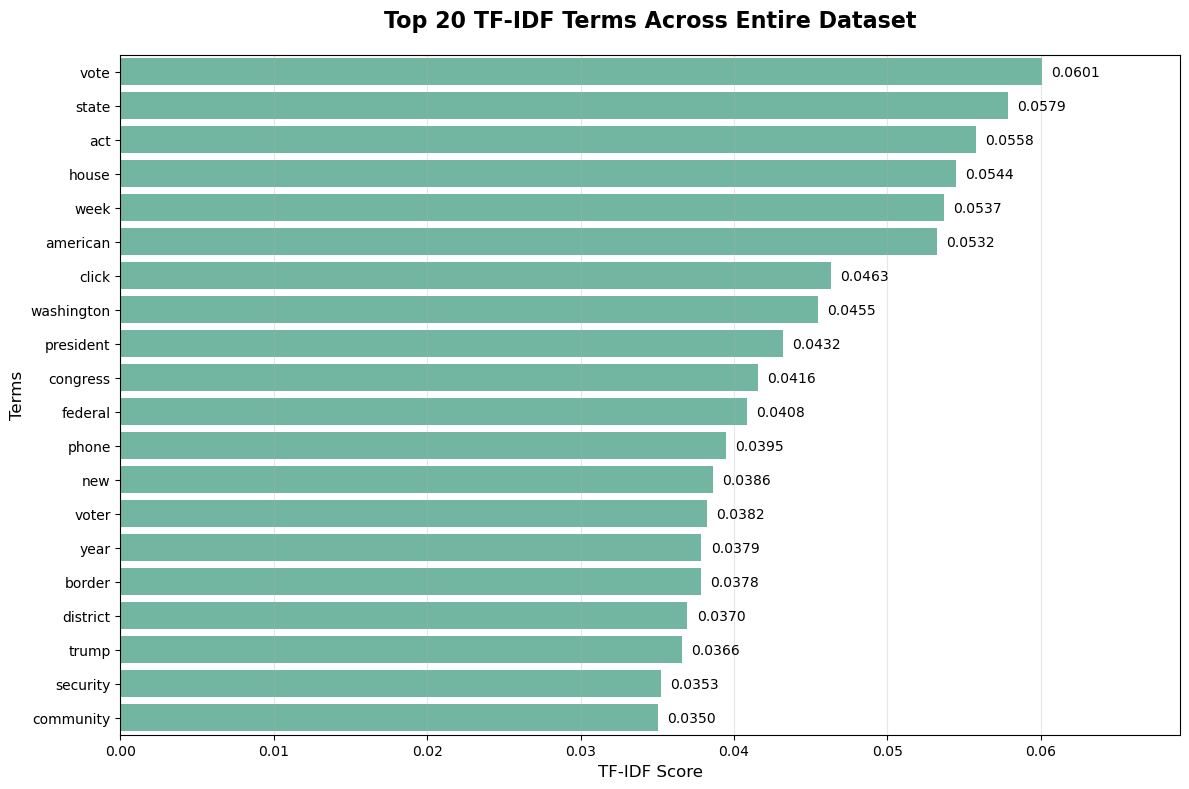

In [ ]:
plt.style.use('default')
sns.set_palette("Set2")

plt.figure(figsize=(12, 8))
top_20_tfidf = full_tfidf_df.head(20)

ax = sns.barplot(data=top_20_tfidf, y='word', x='tfidf_score', orient='h')

plt.title('Top 20 TF-IDF Terms Across Entire Dataset', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('TF-IDF Score', fontsize=12)
plt.ylabel('Terms', fontsize=12)

max_score = top_20_tfidf['tfidf_score'].max()
for i, v in enumerate(top_20_tfidf['tfidf_score']):
    ax.text(v + (max_score * 0.01), i, f'{v:.4f}', va='center', fontsize=10, ha='left')

plt.xlim(0, max_score * 1.15)

# Improve layout
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

In [533]:
print(f"Total documents: {len(df)}")
print(f"Republican documents: {len(r_df)}")
print(f"Democrat documents: {len(d_df)}")


# Fit and transform Republican documents
print("\nCalculating TF-IDF for Republican documents...")
r_tfidf_matrix = tfidf_vectorizer.fit_transform(r_df['Body'])
r_feature_names = tfidf_vectorizer.get_feature_names_out()

# Get mean TF-IDF scores for Republican documents
r_mean_scores = np.mean(r_tfidf_matrix.toarray(), axis=0)
r_tfidf_df = pd.DataFrame({
    'word': r_feature_names,
    'tfidf_score': r_mean_scores
}).sort_values('tfidf_score', ascending=False)

print("Top 15 Republican TF-IDF words:")
print(r_tfidf_df.head(15))

# Fit and transform Democrat documents
print("\nCalculating TF-IDF for Democrat documents...")
d_tfidf_matrix = tfidf_vectorizer.fit_transform(d_df['Body'])
d_feature_names = tfidf_vectorizer.get_feature_names_out()

# Get mean TF-IDF scores for Democrat documents
d_mean_scores = np.mean(d_tfidf_matrix.toarray(), axis=0)
d_tfidf_df = pd.DataFrame({
    'word': d_feature_names,
    'tfidf_score': d_mean_scores
}).sort_values('tfidf_score', ascending=False)

print("Top 15 Democrat TF-IDF words:")
print(d_tfidf_df.head(15))


Total documents: 1677
Republican documents: 1148
Democrat documents: 529

Calculating TF-IDF for Republican documents...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top 15 Republican TF-IDF words:
          word  tfidf_score
861      state     0.060262
66    american     0.057674
975       week     0.056950
437      house     0.056773
34         act     0.055199
964       vote     0.053977
171      click     0.049300
123     border     0.047015
334    federal     0.043178
200   congress     0.042974
682  president     0.041879
658      phone     0.040052
276   district     0.039010
115      biden     0.038417
996       year     0.038040

Calculating TF-IDF for Democrat documents...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top 15 Democrat TF-IDF words:
           word  tfidf_score
957        vote     0.072060
625      office     0.061458
46          act     0.056003
850       state     0.053031
923       trump     0.051507
435       house     0.049065
689   president     0.046345
959       voter     0.046188
972        week     0.045095
778       right     0.044913
966  washington     0.043732
74     american     0.043216
613         new     0.041224
176       click     0.040754
666       phone     0.038815


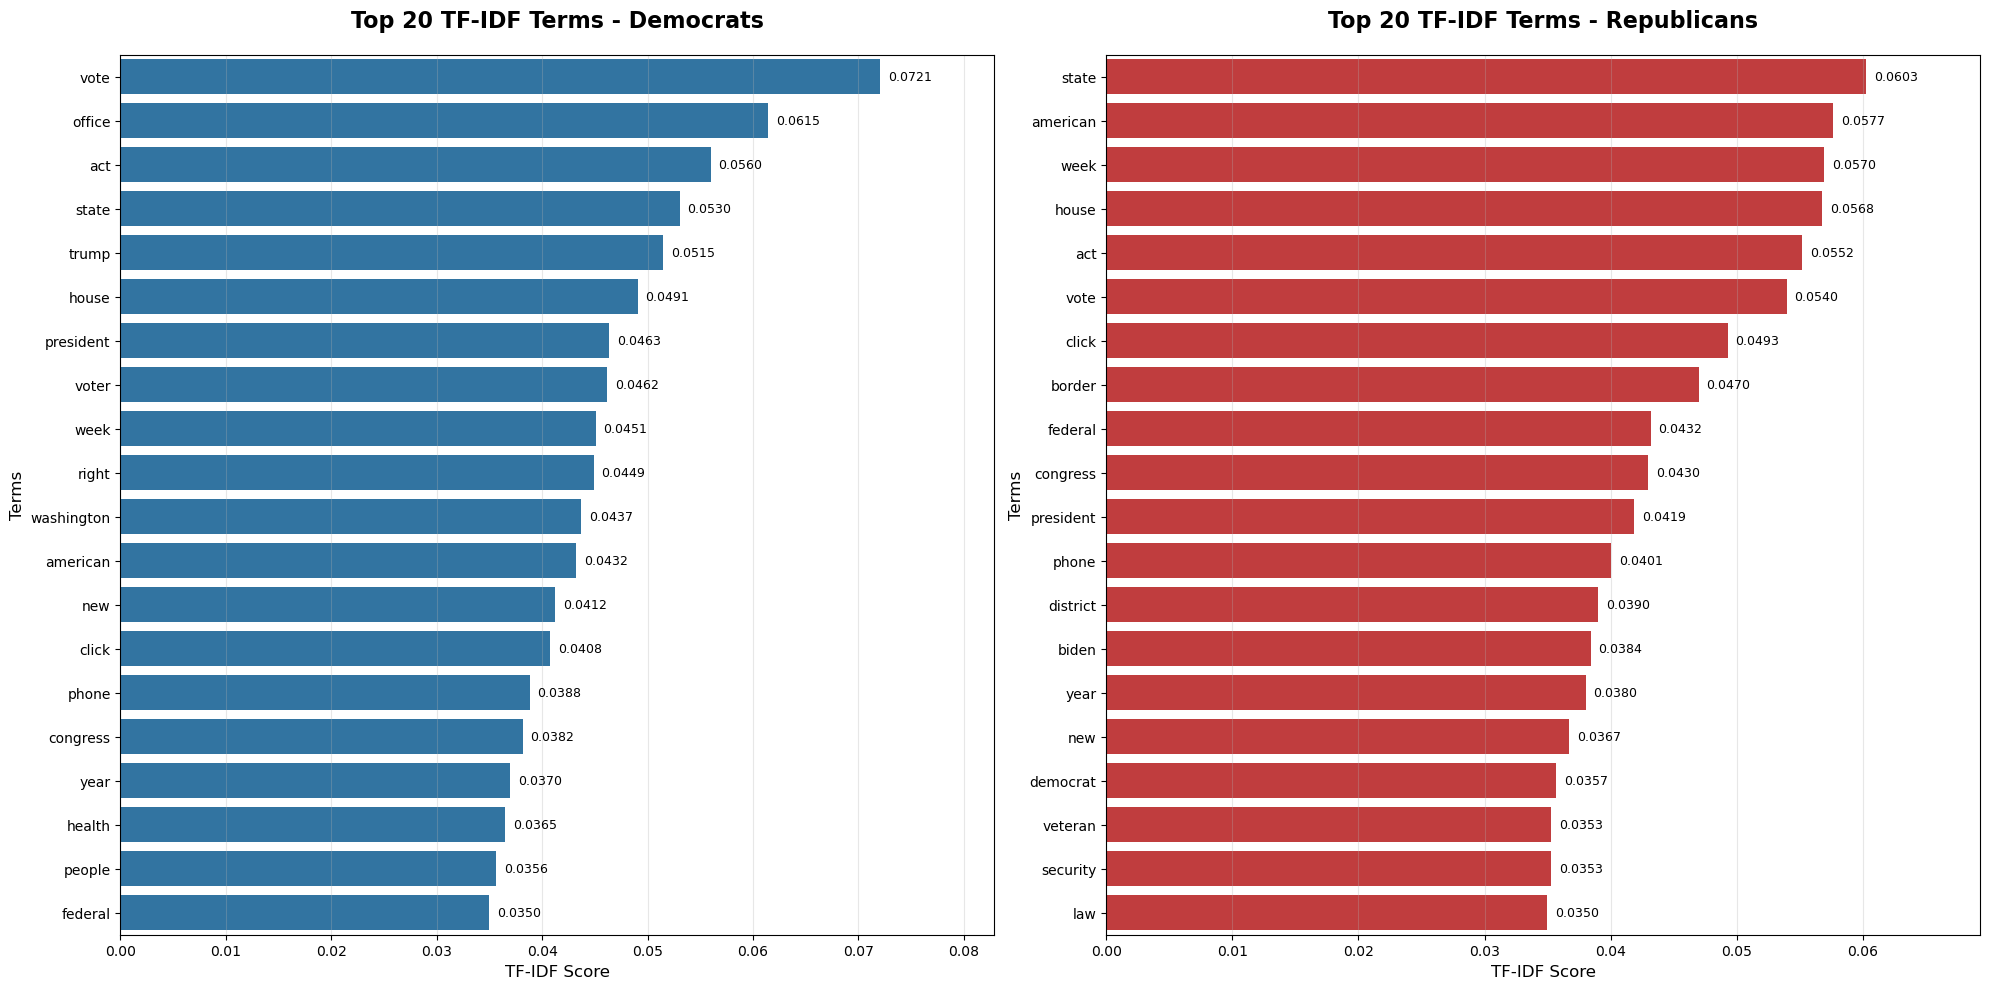

In [ ]:
democrat_color = '#1f77b4'  # democratic blue
republican_color = '#d62728'  # rep red

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Democrat plot (left)
dem_top_20 = d_tfidf_df.head(20)
sns.barplot(data=dem_top_20, y='word', x='tfidf_score', orient='h', color=democrat_color, ax=ax1)
ax1.set_title('Top 20 TF-IDF Terms - Democrats', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('TF-IDF Score', fontsize=12)
ax1.set_ylabel('Terms', fontsize=12)

dem_max_score = dem_top_20['tfidf_score'].max()
for i, v in enumerate(dem_top_20['tfidf_score']):
    ax1.text(v + (dem_max_score * 0.01), i, f'{v:.4f}', va='center', fontsize=9, ha='left')
ax1.set_xlim(0, dem_max_score * 1.15)
ax1.grid(axis='x', alpha=0.3)

# Republican plot (right)
rep_top_20 = r_tfidf_df.head(20)
sns.barplot(data=rep_top_20, y='word', x='tfidf_score', orient='h', color=republican_color, ax=ax2)
ax2.set_title('Top 20 TF-IDF Terms - Republicans', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('TF-IDF Score', fontsize=12)
ax2.set_ylabel('Terms', fontsize=12)

rep_max_score = rep_top_20['tfidf_score'].max()
for i, v in enumerate(rep_top_20['tfidf_score']):
    ax2.text(v + (rep_max_score * 0.01), i, f'{v:.4f}', va='center', fontsize=9, ha='left')
ax2.set_xlim(0, rep_max_score * 1.15)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## TF-IDF Implementation Approach

Initially, I attempted to implement TF-IDF analysis using the manual approach from the sample notebook `7_countingwords.ipynb`, building custom functions to calculate term frequency and inverse document frequency from scratch. However, this approach proved to be computationally inefficient when applied to our large political dataset containing thousands of documents. The manual implementation required nested loops to process each word in each document, resulting in extremely slow processing times that would have taken hours to complete. Recognizing the performance limitations of the manual approach, I transitioned to using scikit-learn's `TfidfVectorizer`, which leverages optimized algorithms and sparse matrix representations to handle large-scale text processing efficiently. This change not only dramatically improved processing speed but also provided built-in preprocessing capabilities like stopword removal and tokenization, making the analysis both faster and more robust for our political communication dataset.
